# Custom Transformer

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import set_config; set_config(display='diagram')

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

👇 Consider the following dataset

In [3]:
data = pd.read_csv("data.csv")
data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14
...,...,...,...,...,...,...,...
995,RJ,SP,16800,63,58,24,30
996,RS,SP,675,40,18,35,19
997,RJ,SP,2050,45,15,35,32
998,BA,SP,8750,52,51,17,33


- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.

🎯 The target is the number of days between the order and the delivery.

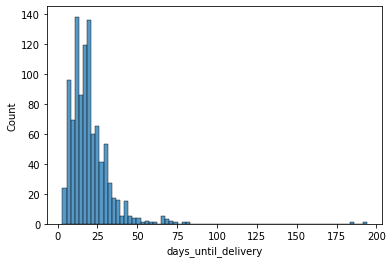

In [5]:
# Check target
sns.histplot(data.days_until_delivery);

## 1. Pipeline

👇 Create a scikit-learn pipeline named `pipe`:

- Engineer a `volume` feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Add a default `Ridge` regression estimator

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look wierd, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse=True)`. Use `.todense()` to turn it back to a dense matrix

</details>

In [7]:
X = data.drop(columns = ['days_until_delivery'])
y = data['days_until_delivery']
X.dtypes

customer_state       object
seller_state         object
product_weight_g      int64
product_length_cm     int64
product_height_cm     int64
product_width_cm      int64
dtype: object

In [8]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge


def volume(data):
    volume = data["product_length_cm"] * data["product_height_cm"] * data['product_width_cm']
    return pd.DataFrame(volume)

volume_computer = Pipeline([
    ('compute_volume', FunctionTransformer(volume)),
    ('scaler', StandardScaler())])

cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ('num_tr', StandardScaler(), make_column_selector(dtype_include = 'int64')),
    ('cat_tr', cat_transformer, make_column_selector(dtype_include = 'object')),
    ('vol_tr', volume_computer, 
     ['product_length_cm', 'product_width_cm', 'product_height_cm']),
    ])

df_transformed = pd.DataFrame(preprocessor.fit_transform(X))
pipe = make_pipeline(preprocessor, Ridge())
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_tr', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4debda66a0>),
                                                 ('cat_tr',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4debda6730>),
                                                 ('vol_tr',
                                                  Pipeline(steps=[('compute_volume',
                                                                   FunctionTransformer(func=<function volume at 0x7f4debd42c10>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['product_length_cm',
                                                   'product_width_cm',
                                                   'product_height_cm'])])),
                ('ridge', Ridge())])

#### 🧪 Test your pipe

In [9]:
from nbresult import ChallengeResult

pipe_test = pipe

# Check that it doesn't crash
assert pipe_test.fit(X,y)

result = ChallengeResult('pipe', 
                         shape = pipe_test[:-1].fit_transform(X).shape
)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-7.1.2, pluggy-1.0.0 -- /bin/python3
cachedir: .pytest_cache
rootdir: /home/quantium/labs/lewagon/data-challenges/05-ML/08-Workflow/02-Custom-Transformer/tests
plugins: dash-1.19.0, anyio-3.6.1
collecting ... collected 1 item

test_pipe.py::TestPipe::test_pipe_not_crashing PASSED                    [100%]

============================== 1 passed in 0.40s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master



## 2. Train and Predict

👇 Let's imagine `data` is your entire training set.

- `cross_validate` your pipeline on this dataset (❗️low r2 score are expected)
- Now, imagine you just received an new order `new_data`: predict it's duration of delivery in a variable `prediction`

In [10]:
new_data = pd.read_csv("data_new.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [11]:
prediction = pipe.predict(new_data)
prediction

array([20.68579164])

In [12]:
from nbresult import ChallengeResult

result = ChallengeResult('prediction',
    prediction = prediction
)
result.write()
print(result.check())



============================= test session starts ==============================
platform linux -- Python 3.8.10, pytest-7.1.2, pluggy-1.0.0 -- /bin/python3
cachedir: .pytest_cache
rootdir: /home/quantium/labs/lewagon/data-challenges/05-ML/08-Workflow/02-Custom-Transformer/tests
plugins: dash-1.19.0, anyio-3.6.1
collecting ... collected 1 item

test_prediction.py::TestPrediction::test_prediction PASSED               [100%]

============================== 1 passed in 0.45s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master



🏁 Congratulation. Don't forget to add, commit and push your notebook.